In [10]:
import sys
sys.path.append('..')
import os
import umap.umap_ as umap
import matplotlib.pyplot as plt
from fasta_preprocessing_tools import reduce_and_align_sequences
from amino_acid_encoding import SequenceEncoder, read_encoding_file
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

parent_dir = os.path.abspath('..')                # path to parent directory
data_dir = parent_dir + '/data/spike_proteins/'   # path to datasets


In [2]:
def encode_sequences(infile, encoding_type):
    encoder = SequenceEncoder(encoding_type = encoding_type)
    frequencies, encoded_sequences = encoder.encode_from_fasta_file(infile, f'1_in_500_encoded_{encoding_type}.txt')
    return frequencies, encoded_sequences

In [3]:
def embed_with_PCA(encoded_sequences):
     reducer = PCA(n_components = 2)
     sequence_embeddings = reducer.fit_transform(encoded_sequences)
     explained_variance = reducer.explained_variance_ratio_
     return sequence_embeddings, explained_variance


In [4]:
def embed_with_tSNE(encoded_sequences, PCA_dimension = 50):
     pca = PCA(n_components = PCA_dimension)
     pca_reduced_embeddings = pca.fit_transform(encoded_sequences)
     reducer = TSNE(init='pca')
     sequence_embeddings = reducer.fit_transform(pca_reduced_embeddings)
     return sequence_embeddings

In [5]:
def embed_with_UMAP(encoded_sequences, metric, seed):
     reducer = umap.UMAP(metric=metric, random_state=seed)
     sequence_embeddings = reducer.fit_transform(encoded_sequences)
     return sequence_embeddings

In [6]:
def plot_2D_map(embeddings, frequencies, labels = None, markerSize = 5, method='PCA'):
     assert method == 'PCA' or method == 'UMAP' or method == 'tSNE', "method must be either PCA, UMAP or tSNE"
     marker_sizes = [frequency * markerSize for frequency in frequencies]

     # plot
     plt.scatter(embeddings[:,0],
                 embeddings[:,1],
                  s=marker_sizes, alpha=0.25)
     plt.gca().set_aspect('equal', 'datalim')
     plt.gcf().set_size_inches(12, 12)
     plt.title('2D embeddings of SARS-COV19 spike proteins', fontsize=20)
     if labels is not None:
         plt.gca().text(0.95, 0.95, '\n'.join(labels), horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes)

     # axes labels
     if method == 'PCA':
         plt.xlabel('PCA 1')
         plt.ylabel('PCA 2')
     elif method == 'tSNE':
         plt.xlabel('tSNE 1')
         plt.ylabel('tSNE 2')
     elif method == 'UMAP':
         plt.xlabel('UMAP 1')
         plt.ylabel('UMAP 2')

     plt.show()

In [7]:
def generate_2D_map(aligned_fasta_file, encoding_type='PAM250', UMAP_metric='cosine', seed=42, markerSize=1, method='PCA'):
     assert method == 'PCA' or method == 'UMAP' or method == 'tSNE', "method must be either PCA, UMAP or tSNE"

     # encoded the protein sequences
     frequencies, encoded_sequences = encode_sequences(infile=aligned_fasta_file, encoding_type=encoding_type)

     # compute the sequence embeddings
     if method == 'PCA':
         sequence_embeddings, explained_variance = embed_with_PCA(encoded_sequences)
         labels = ['PCA', encoding_type, ', '.join([str(var) for var in explained_variance])]
     elif method == 'tSNE':
         sequence_embeddings = embed_with_tSNE(encoded_sequences)
         labels = ['tSNE', encoding_type]
     elif method == 'UMAP':
         sequence_embeddings = embed_with_UMAP(encoded_sequences, metric = UMAP_metric, seed=seed)
         labels = ['UMAP', encoding_type, UMAP_metric, f'seed: {seed}']

     # plot the result
     plot_2D_map(sequence_embeddings, frequencies, markerSize=markerSize, labels=labels, method=method)

In [ ]:
# TESTING preprocessing pipeline
reduce_and_align_sequences(infile='spikeprot0112.fasta',
                           outfile='aligned_spike_proteins.fasta',
                           reduction_factor=100,
                           length_cutoff=1200,
                           invalid_amino_acid_cutoff=1)

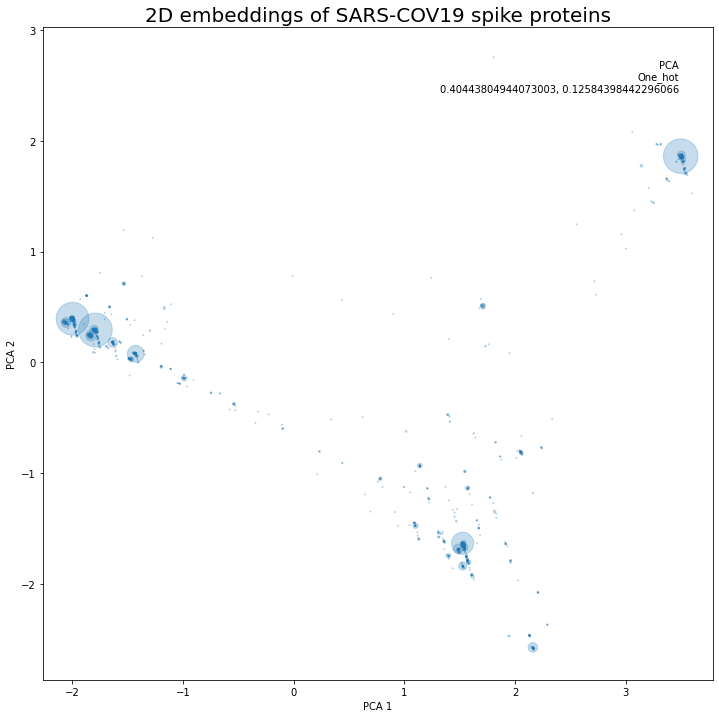

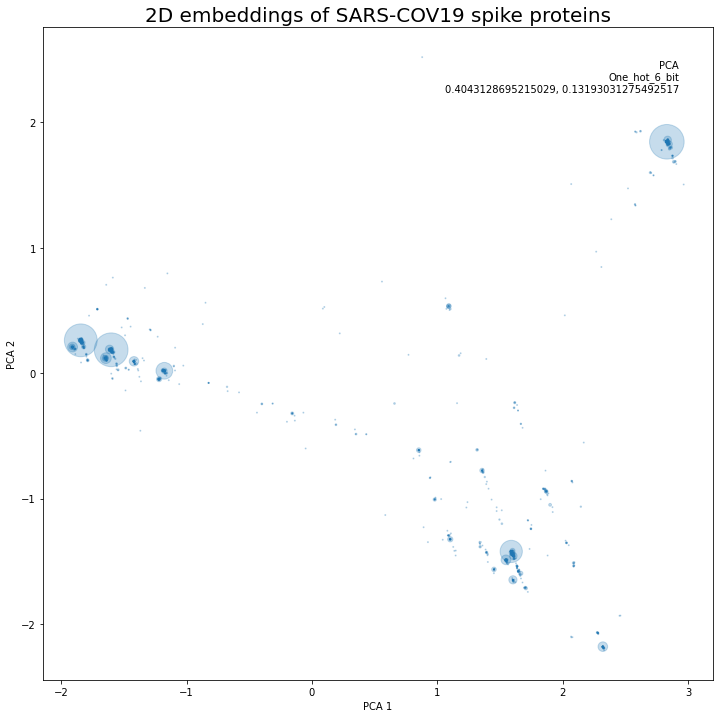

KeyboardInterrupt: 

In [8]:
for method in ['PCA', 'tSNE', 'UMAP']:
     for encoding_type in ['One_hot', 'One_hot_6_bit', 'Binary_5_bit', 'Hydrophobicity_matrix',
                       'Meiler_parameters', 'Acthely_factors', 'PAM250', 'BLOSUM62', 'Miyazawa_energies',
                       'Micheletti_potentials', 'AESNN3', 'ANN4D', 'ProtVec']:
         if method == 'UMAP' and encoding_type == 'PAM250':
             for metric in ['cosine', 'euclidean']:
                 for seed in [1, 42]:
                     generate_2D_map('1_in_500_cleaned_aligned.afa', encoding_type=encoding_type, method=method, UMAP_metric=metric, seed=seed)
         else:
             generate_2D_map('1_in_500_cleaned_aligned.afa', encoding_type=encoding_type, method=method)
